In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
folder = 'drive/MyDrive/Colab Notebooks/uncertainty'

In [3]:
%cd '{folder}'
%pwd

/content/drive/MyDrive/Colab Notebooks/uncertainty


'/content/drive/MyDrive/Colab Notebooks/uncertainty'

In [19]:
%ls

data/  model/  scripts/  train.ipynb  utils/  weights/


## Prepare environement

In [20]:
!pip install libpysal torch_geometric geopandas torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Training

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from utils.prepare_data import prepare_input
from utils.class_loss import MVELoss
from utils.evaluate import evaluate
from model.class_GCN import GCN_LSTM

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Define hyperparameters
n_features = 2
n_stations = 63
hid_g = 64
hid_fc = 64
hid_l = 64
meanonly = False
homo = 0
batch_size = 32
learning_rate = 0.0001
weight_decay = 0.001
dropout = 0.2
num_epochs = 20
nadj = ['euc','con','func']
dist = 'lognorm'
z = 0.95

# Define other parameters
SAVEPATH = "./weights/model_lognorm.pt"
filepath = 'data/processed/0620.npz'
adjfile = 'data/processed/adjlist.csv'

In [51]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Create the network
net = GCN_LSTM(n_features,n_stations,hid_g,hid_fc,hid_l,meanonly,homo,nadj,device,dropout)
net = net.to(device)

# Define the loss function
loss_fn = MVELoss(dist)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Read in and prepare dataset
data = data = np.load(filepath)
x = data['x']
y = data['y']
adj = pd.read_csv(adjfile)
history = data['history']
weather = data['weather']
los = data['los']

train_loader,val_loader,test_loader,adj_torch = prepare_input(x,y,adj,nadj,history,weather,los,device,batch_size=batch_size)
train_num = len(train_loader.dataset)
eval_num = len(val_loader.dataset)
batch_number = len(train_loader)

In [52]:
print('Start training ...')
print(f"Training sample:{train_num}")

# Training loop
loss_history = []
loss_eval = []
for epoch in range(1,num_epochs+1):

    running_loss = 0.0

    # Iterate over the batches
    for i,traindata in enumerate(train_loader,1):

        net.train()

        batch_x, batch_y, batch_history, batch_weather, batch_los = traindata

        batch_x = batch_x.float()
        batch_y = torch.squeeze(batch_y).float()
        batch_history = batch_history.float()

        batch_x, batch_y, batch_history, batch_weather, batch_los = \
                batch_x.to(device), batch_y.to(device), batch_history.to(device), \
                batch_weather.to(device), batch_los.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = net(batch_x, adj_torch, batch_history, batch_weather, batch_los, device)

        # Compute the loss
        if outputs.shape[0]!=2*batch_size:
            batch_new = int((outputs.shape[0])/2)
            output_loc = outputs[:batch_new,:]
            output_scale = outputs[batch_new:,:]
        else:
            output_loc = outputs[:batch_size,:]
            output_scale = outputs[batch_size:,:]
        loss = loss_fn(output_loc, output_scale, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # if i%20 == 0:
        #   print('Ep:', epoch, 'Batch:', i, 'Loss:', loss)
        running_loss += loss.item()

    # Print the average loss for the epoch and evaluate
    loss_history.append(running_loss/train_num)

    ################ Evaluate ###############
    net.eval()

    eval_loss = 0

    for j,evaldata in enumerate(val_loader):
        batch_x, batch_y, batch_history, batch_weather, batch_los = evaldata

        batch_x = batch_x.float()
        batch_y = torch.squeeze(batch_y).float()
        batch_history = batch_history.float()

        batch_x, batch_y, batch_history, batch_weather, batch_los = \
            batch_x.to(device), batch_y.to(device), batch_history.to(device), \
            batch_weather.to(device), batch_los.to(device)

        outputs = net(batch_x, adj_torch, batch_history, batch_weather, batch_los, device)
        if outputs.shape[0]!=2*batch_size:
            batch_new = int((outputs.shape[0])/2)
            output_loc = outputs[:batch_new,:]
            output_scale = outputs[batch_new:,:]
        else:
            output_loc = outputs[:batch_size,:]
            output_scale = outputs[batch_size:,:]

        loss = loss_fn(output_loc, output_scale, batch_y)
        eval_loss += loss.item()

    loss_eval.append(eval_loss/eval_num)

    # Save best model
    if epoch == 1:
        loss_best = eval_loss
    else:
        if eval_loss < loss_best:
            loss_best = eval_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss history': loss_history,
            'average eval batch loss': eval_loss/eval_num,
            }, SAVEPATH)

    print('Ep:', epoch, '| Average loss;', running_loss/train_num, '| Evaluation loss:',eval_loss/eval_num)

Start training ...
Training sample:4595
Ep: 1 | Average loss; 855.6201463037269 | Evaluation loss: 511.79415627722125
Ep: 2 | Average loss; 356.51826724445726 | Evaluation loss: 287.34572439160496
Ep: 3 | Average loss; 265.23060009181177 | Evaluation loss: 243.21858326981706
Ep: 4 | Average loss; 234.18376387802638 | Evaluation loss: 223.4578042910905
Ep: 5 | Average loss; 221.3419800734494 | Evaluation loss: 215.15284521654507
Ep: 6 | Average loss; 215.44127947752312 | Evaluation loss: 209.15722900815956
Ep: 7 | Average loss; 209.00068683478986 | Evaluation loss: 201.2167681119168
Ep: 8 | Average loss; 201.64027518022306 | Evaluation loss: 193.21771779874476
Ep: 9 | Average loss; 192.6535088241295 | Evaluation loss: 181.0236494217185
Ep: 10 | Average loss; 175.4859623656828 | Evaluation loss: 151.3691380730074
Ep: 11 | Average loss; 154.59309871038494 | Evaluation loss: 138.387177045337
Ep: 12 | Average loss; 148.12898610709672 | Evaluation loss: 135.97981799188807
Ep: 13 | Average lo

In [59]:
print('Testing ...')
z = 0.95
loss, mae, mape, mpiw, picp = evaluate(net, loss_fn, adj_torch, dist, test_loader, z, device, batch_size)
print('Average loss;', loss, '| MAE:',mae, '| MAPE:',mape, '| MPIW',mpiw, '| PICP:',picp)

Testing ...
Average loss; 153.24218505859375 | MAE: 4.609720230102539 | MAPE: 0.3648771345615387 | MPIW 3.7434878688477664e+17 | PICP: 0.9096204278812975


(120.0, 200.0)

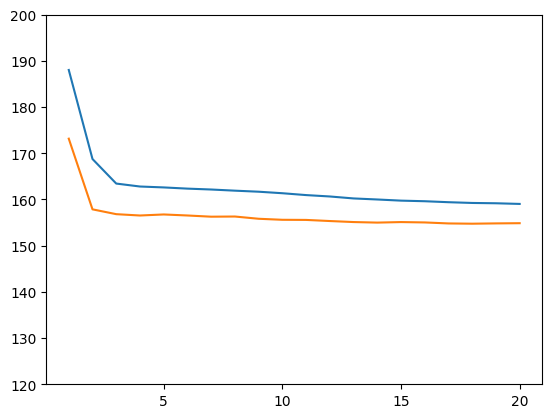

In [ ]:
# Visualize result
plt.plot(range(1,num_epochs+1),loss_history,label='train')
plt.plot(range(1,num_epochs+1),loss_eval,label='validate')
plt.xticks([5,10,15,20])
plt.ylim([120,200])

## Load model

In [60]:
SAVEPATH = 'weights/model_lognorm.pt'
checkpoint = torch.load(SAVEPATH)
trained_model = GCN_LSTM(n_features,n_stations,hid_g,hid_fc,hid_l,meanonly,homo,nadj,device,dropout)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)

GCN_LSTM(
  (batchnorm): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn): GCNLayer(
    (gc1): GCNConv(2, 64)
    (gc2): GCNConv(64, 64)
  )
  (fc1): Linear(in_features=4032, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (lstm): LSTM(64, 64)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (final): Linear(in_features=64, out_features=126, bias=True)
  (recent_on_history_mean): Linear(in_features=64, out_features=63, bias=True)
  (recent_on_history_var): Linear(in_features=64, out_features=63, bias=True)
)

In [61]:
net.eval()
eval_loss = 0
eval_num = len(test_loader.dataset)
for i,evaldata in enumerate(test_loader):
    batch_x, batch_y, batch_history, batch_weather, batch_los = evaldata

    batch_x = batch_x.float()
    batch_y = torch.squeeze(batch_y).float()
    batch_history = batch_history.float()

    batch_x, batch_y, batch_history, batch_weather, batch_los = \
        batch_x.to(device), batch_y.to(device), batch_history.to(device), \
        batch_weather.to(device), batch_los.to(device)

    outputs = net(batch_x, adj_torch, batch_history, batch_weather, batch_los, device)
    if outputs.shape[0]!=2*batch_size:
        batch_new = int((outputs.shape[0])/2)
        output_loc = outputs[:batch_new,:]
        output_scale = outputs[batch_new:,:]
    else:
        output_loc = outputs[:batch_size,:]
        output_scale = outputs[batch_size:,:]
    loss = loss_fn(output_loc, output_scale, batch_y)

    loss = loss_fn(output_loc, output_scale, batch_y)
    eval_loss += loss.item()

    # Get mean and variance
    if i == 0:
        test_out_mean = outputs[:batch_size,:].cpu().detach().numpy()
        test_out_var = outputs[batch_size:,:].cpu().detach().numpy()
        y_eval = batch_y.cpu().numpy()
    else:
        if outputs.shape[0]==2*batch_size:
            test_out_mean = np.concatenate((test_out_mean, outputs[:batch_size,:].cpu().detach().numpy()), axis=0)
            test_out_var = np.concatenate((test_out_var, outputs[batch_size:,:].cpu().detach().numpy()), axis=0)
            y_eval = np.concatenate((y_eval, batch_y.cpu().numpy()), axis=0)
        else:
            batch_new = int((outputs.shape[0])/2)
            test_out_mean = np.concatenate((test_out_mean, outputs[:batch_new,:].cpu().detach().numpy()), axis=0)
            test_out_var = np.concatenate((test_out_var, outputs[batch_new:,:].cpu().detach().numpy()), axis=0)
            y_eval = np.concatenate((y_eval, batch_y.cpu().numpy()), axis=0)

In [62]:
test_out_mean[0]

array([1.3982775e+00, 3.4938767e-03, 1.7847983e+00, 3.0080655e-01,
       2.1871939e+00, 2.2970231e+00, 2.6642391e-01, 5.3267562e-01,
       2.7871368e+00, 2.1236227e+00, 2.6171114e+00, 1.9567933e+00,
       1.9804429e+00, 3.0356202e+00, 1.8129634e+00, 5.4853487e-01,
       1.9828205e+00, 1.9710183e+00, 2.3069441e+00, 2.0363414e+00,
       2.3604550e+00, 1.5571058e+00, 2.5299632e-03, 1.3578678e+00,
       6.4327824e-01, 4.9793920e-03, 1.8184583e+00, 1.7601017e+00,
       1.8838869e+00, 2.1711044e+00, 1.6434356e+00, 1.9582345e+00,
       2.5217128e+00, 1.3088381e+00, 7.9490191e-01, 2.1260023e+00,
       3.0547404e+00, 2.3622332e+00, 2.3885407e+00, 2.4435279e+00,
       1.7313293e+00, 2.3598790e+00, 2.0825906e+00, 4.2431667e-01,
       1.7615247e+00, 6.0069364e-01, 1.9042569e+00, 3.0744550e+00,
       2.6143281e+00, 1.6088120e+00, 1.7458583e+00, 2.7890339e+00,
       2.0376880e+00, 2.2036679e+00, 2.1352069e+00, 2.3155382e+00,
       1.6276234e+00, 2.1928945e+00, 2.4980204e+00, 2.6621358e

In [63]:
test_out_var[0]

array([ 0.8537323 ,  8.912129  ,  0.7591599 ,  2.614223  ,  0.5591762 ,
        0.4943586 ,  2.3374674 ,  2.359673  ,  0.39078045,  0.7421129 ,
        0.45980096,  0.6167732 ,  0.64245534,  0.5569731 ,  0.71163416,
        2.2014556 ,  0.63734186,  0.7597417 ,  0.5992208 ,  0.6485914 ,
        0.73487663,  0.92505455, 10.022287  ,  1.0671713 ,  2.7839804 ,
        9.245541  ,  0.88992816,  0.8360738 ,  0.64316434,  0.5912757 ,
        0.8735645 ,  0.6740338 ,  0.60823065,  1.1478202 ,  1.9914275 ,
        0.6537276 ,  0.8943944 ,  0.7029501 ,  0.6495994 ,  0.5289739 ,
        0.77861947,  0.5470755 ,  0.6464859 ,  2.527106  ,  0.87316793,
        2.2272434 ,  0.5388149 ,  0.6170857 ,  0.53026277,  0.9687251 ,
        0.69690025,  0.509     ,  0.7280529 ,  0.589019  ,  0.612691  ,
        0.7112376 ,  0.90431213,  0.47556484,  0.4642192 ,  0.5422516 ,
        1.4528565 ,  1.1734804 ,  0.6980846 ], dtype=float32)

In [37]:
print('Testing ...')
loss, mae, mape, mpiw, picp = evaluate(trained_model, loss_fn, adj_torch, dist, test_loader, z, device, batch_size)
print('Average loss;', loss, '| MAE:',mae, '| MAPE:',mape, '| MPIW',mpiw, '| PICP:',picp)

Testing ...
Average loss; 170.63421492866848 | MAE: 3.2112367153167725 | MAPE: 0.25418177247047424 | MPIW 15.267463920010444 | PICP: 0.9318978605935128
